In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(style='ticks')
sns.set_context("notebook", font_scale=1)
sns.set_style("darkgrid")


import warnings
warnings.filterwarnings('ignore')
import datetime
from datetime import date

%matplotlib inline

## Get the patients data

In [2]:
patients = pd.read_csv("./data/Patient.csv")

In [3]:
patients.head(2)

,PatientGuid,Gender,YearOfBirth,State,PracticeGuid
0,BC78C551-C20F-4F10-8D61-002AA9834BDE,F,1981,NY,3E08ED81-B9A1-4525-8308-0E991BCFA87F
1,6D88901A-3214-4BC0-B139-002EF1A5FA09,M,1937,SD,7BF4DAD8-5F67-4985-B911-20C9E89A3737


In [4]:
### Since only one numeric field is there in database and that's integer, changing display format of float to integer
pd.set_option('display.float_format', lambda x: '%d' % x)
patients.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
PatientGuid,4979,4979,644EBCE8-87A4-435D-8306-EB3C4743642B,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gender,4979,2,F,2850,NaN,NaN,NaN,NaN,NaN,NaN,NaN
YearOfBirth,4979,NaN,NaN,NaN,1957,17,1922,1944,1957,1970,1994
State,4979,46,CA,942,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PracticeGuid,4979,317,4D27688B-C925-4513-9CF9-8D281ACC6712,289,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### _There are total 4979 patients scattered across 46 states. They are affiliated across 317 practices._

## Calculate patient's age
Calculating age of the patient based upon current year

In [5]:
patients['Age'] = datetime.datetime.now().year - patients.YearOfBirth

#### Patients distribution by age

Visualizing how patients are distributed acorss different age group

Text(0,0.5,'Number of Patients')

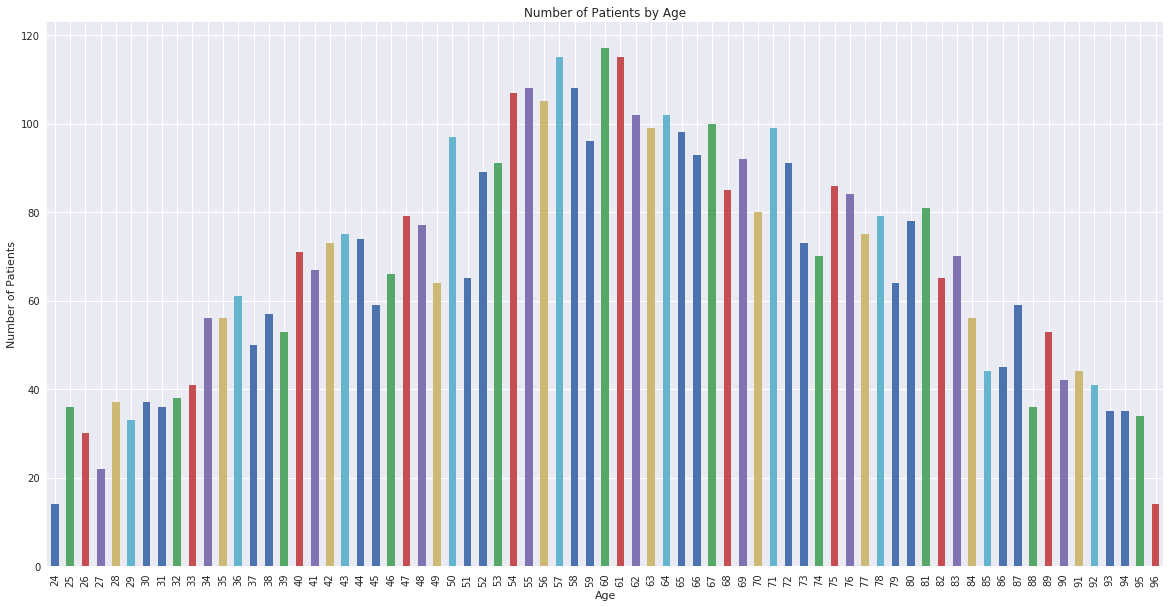

In [6]:
ax = patients.Age.value_counts().sort_index().plot(kind='bar', figsize=(20, 10),stacked=True,title='Number of Patients by Age')
ax.set_xlabel("Age")
ax.set_ylabel("Number of Patients")

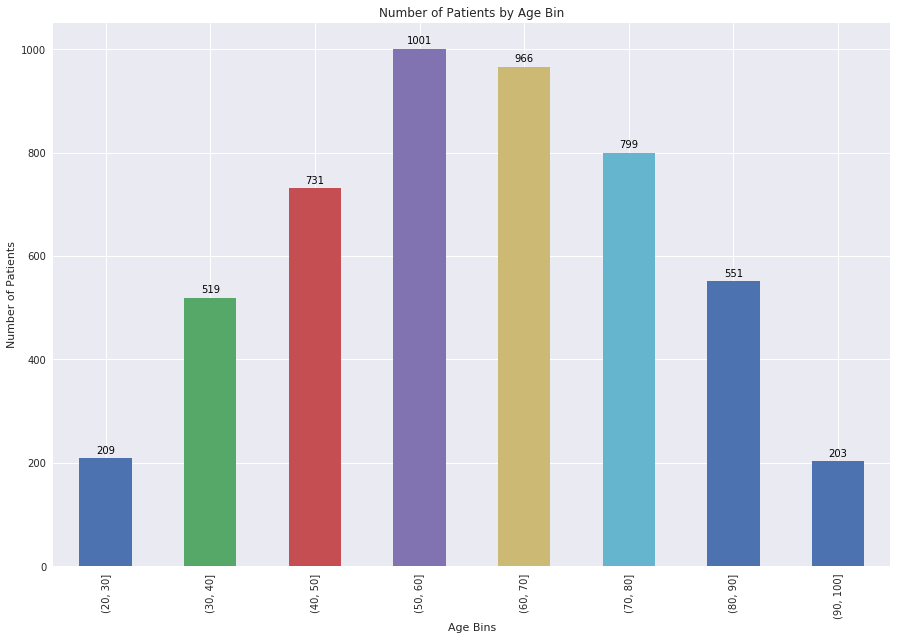

In [7]:
bins = [20,30,40,50,60,70,80,90,100]
patients['age_bins'] = pd.cut(patients['Age'], bins)
ax = patients.age_bins.value_counts().sort_index().plot(kind='bar', figsize=(15, 10),stacked=True,title='Number of Patients by Age Bin')
ax.set_xlabel("Age Bins")
ax.set_ylabel("Number of Patients")
for index, row in patients.age_bins.value_counts().sort_index().reset_index().iterrows():
    ax.text(row.name,row["age_bins"]+10, row["age_bins"], color='black', ha="center")

_Although we have patients starting from 24 years to 96 years of ago, majority of patients are between 40 and 80 years old._

## Patients breakdown by Gender

In [8]:
### Function to calculate percentage for pie chart
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct

Text(0,0.5,'')

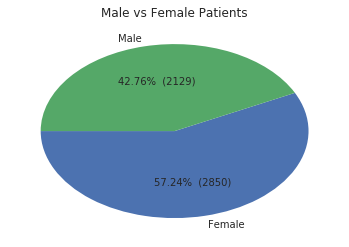

In [9]:
labels = 'Female','Male'
ax = patients.Gender.value_counts().plot.pie(autopct=make_autopct(patients.Gender.value_counts()),startangle = 180,title='Male vs Female Patients',labels=labels)
ax.set_ylabel('')

## Patients by State

Text(0,0.5,'Number of Patients')

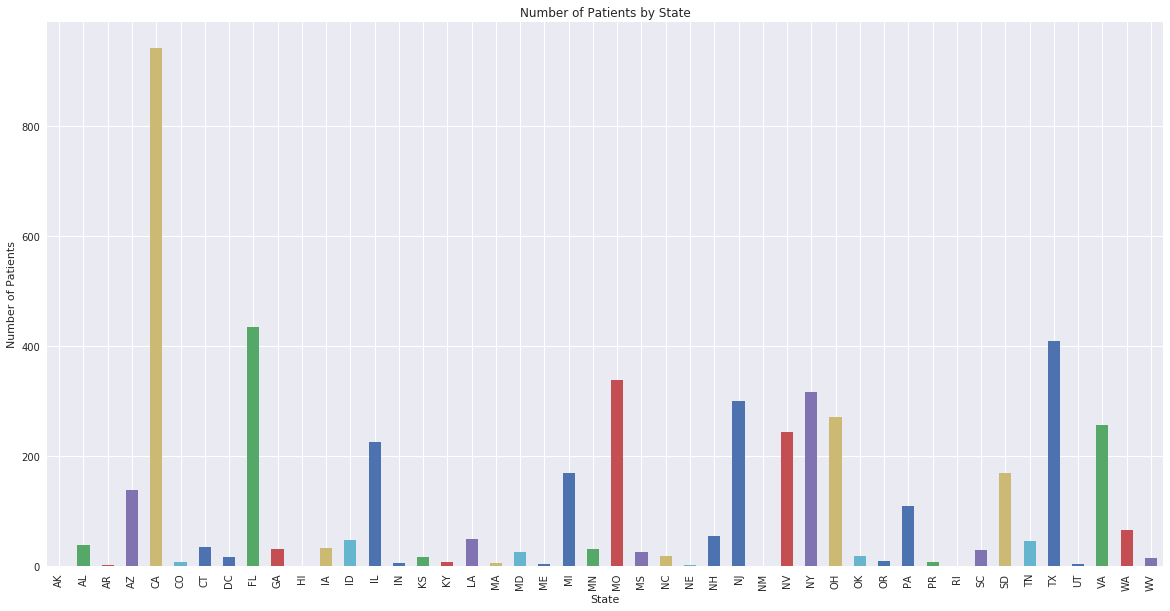

In [10]:
ax = patients.State.value_counts().sort_index().plot(kind='bar', figsize=(20, 10),stacked=True,title='Number of Patients by State')
ax.set_xlabel("State")
ax.set_ylabel("Number of Patients")

## Load Medication data

In [11]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
medicines = pd.read_csv("./data/Medication.csv")
medicines.head(2)

,MedicationGuid,PatientGuid,NdcCode,MedicationName,MedicationStrength,Schedule,DiagnosisGuid,UserGuid
0,6B6B34D1-8F67-4804-9493-0002123D0D2F,070A6571-6DAA-4F1B-8B0C-84C204CC26A6,00378710177,Fenofibrate oral tablet,160 mg,nan,93EE54EE-BA6D-474C-8125-17188579D5AD,263EF64B-D26D-4842-BA47-32D09692AA90
1,2C82278D-C7D2-4258-B9AC-000374032F46,78D10955-1AF3-4DFF-A678-FA5B5597C888,00406055262,OxyCODONE Hydrochloride (oxyCODONE) oral tablet,5 mg,2.00,46F8ADBC-BC84-4108-9B53-4B9F55D5E2C3,D6537F06-58E0-4961-8466-920615561CD9


In [12]:
medicines.shape

(21967, 8)

#### Make sure that Medicines table only has data for patients from patient master list

In [13]:
set(medicines.PatientGuid.unique()).issubset(patients.PatientGuid.unique())

True

#### Check how many patients are taking medication.

In [14]:
medicines.PatientGuid.unique().shape

(4940,)

__Note__ : Of total 4979 patients, 4940 patients are taking medications. There are 39 patients who are not taking any medication.

#### Find out number of unique medications

In [15]:
unique_NdcCode = medicines.NdcCode.unique()
unique_NdcCode.shape

(6359,)

In [16]:
unique_MedicationName = medicines.MedicationName.unique()
unique_MedicationName.shape

(1926,)

_There are 6359 unique medications by NDC code. But, there are only 1926 unique medications by Name._ 

#### NDC code assigned to patients

In [17]:
NDCcode_count_by_patient = medicines.groupby("PatientGuid")["NdcCode"].nunique()
NDCcode_count_by_patient = NDCcode_count_by_patient.to_frame().reset_index()
NDCcode_count_by_patient = NDCcode_count_by_patient.rename(index=str, columns={"NdcCode": "NDCcode_unique_count"})
NDCcode_count_by_patient.head()

,PatientGuid,NDCcode_unique_count
0,00033D2D-D57C-48A7-B201-F9183F6E640B,3
1,00044CC1-7911-4C35-B73C-B5623FA3A60F,2
2,00136822-9A6F-4EF5-ACE7-8B5C836F0635,3
3,001EDAC4-4584-4801-8383-4AD784EEA4C9,1
4,002E58E8-8314-4000-9BDC-73D21DDD6880,12


In [18]:
NDCcode_count_by_patient.describe().T

,count,mean,std,min,25%,50%,75%,max
NDCcode_unique_count,4940.00,4.38,4.26,1.00,1.00,3.00,6.00,43.00


In [19]:
np.median(NDCcode_count_by_patient.NDCcode_unique_count.values)

3.0

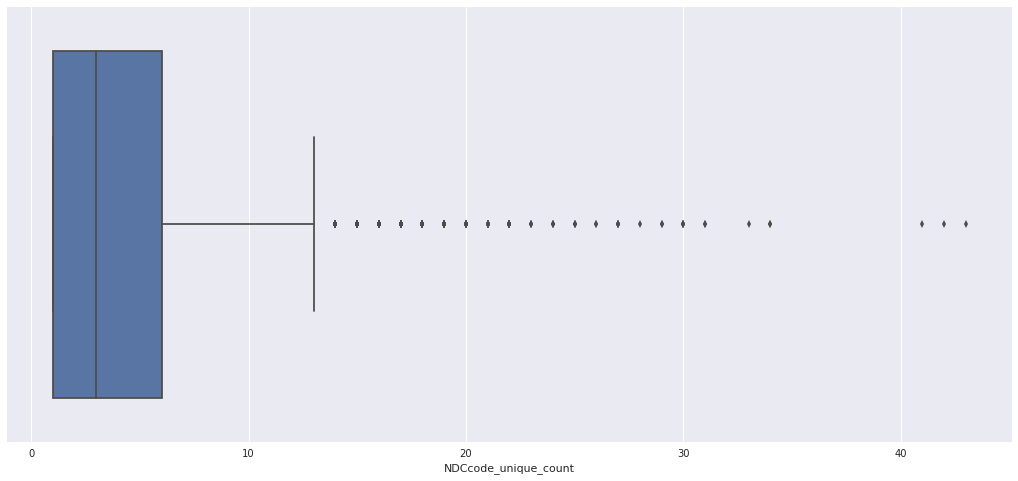

In [20]:
fig, (ax1) = plt.subplots(nrows=1, ncols=1,figsize=(18,8))
sns.boxplot(x="NDCcode_unique_count", data=NDCcode_count_by_patient ,ax=ax1)

__Note: __

1. On the average, each patient takes 4.38 medicines in Medication table.

2. Median for Number of Medication is 3.

3. Majority of patients (~75%) take 6 or less medicines.

4. As can be seen from the box plot, there are quite a few outliers too. They take more than 13 medicines going up to 43 medicines.

#### Medicines assigned to patients by medicine names

In [21]:
MedicationName_count_by_patient = medicines.groupby("PatientGuid")["MedicationName"].nunique()
MedicationName_count_by_patient = MedicationName_count_by_patient.to_frame().reset_index()
MedicationName_count_by_patient = MedicationName_count_by_patient.rename(index=str, columns={"MedicationName": "MedicationName_unique_count"})
MedicationName_count_by_patient.head()

,PatientGuid,MedicationName_unique_count
0,00033D2D-D57C-48A7-B201-F9183F6E640B,2
1,00044CC1-7911-4C35-B73C-B5623FA3A60F,2
2,00136822-9A6F-4EF5-ACE7-8B5C836F0635,3
3,001EDAC4-4584-4801-8383-4AD784EEA4C9,1
4,002E58E8-8314-4000-9BDC-73D21DDD6880,11


In [22]:
MedicationName_count_by_patient.describe().T

,count,mean,std,min,25%,50%,75%,max
MedicationName_unique_count,4940.00,4.16,3.91,0.00,1.00,3.00,5.00,40.00


In [23]:
np.median(MedicationName_count_by_patient.MedicationName_unique_count.values)

3.0

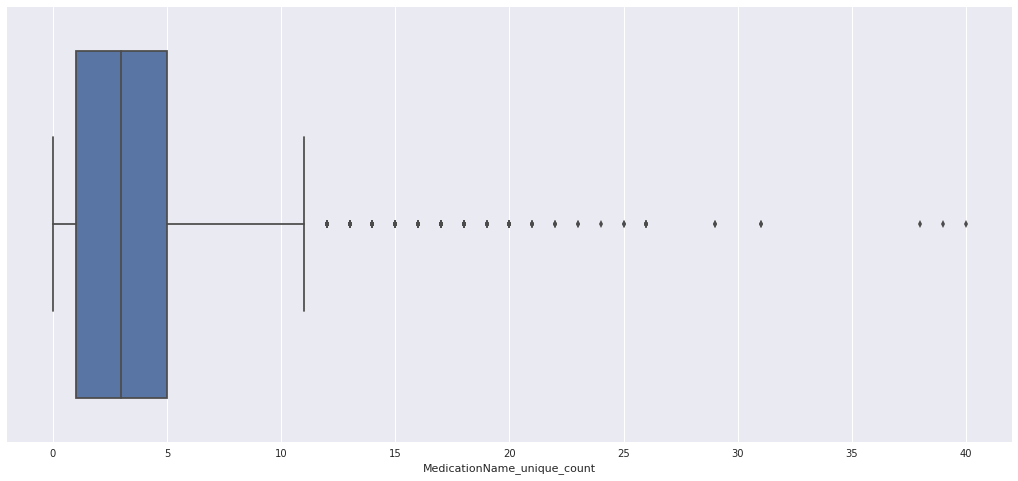

In [24]:
fig, (ax1) = plt.subplots(nrows=1, ncols=1,figsize=(18,8))
sns.boxplot(x="MedicationName_unique_count", data=MedicationName_count_by_patient ,ax=ax1)

___It's interesting to note that even though there are only 1926 medicine names (compare to 6359 unique NDC codes), aggregate statistics didn't change much. We will look into relationship between NDC code and Medicine mapping a little bit later to understand this.  ___

__Note: __

1. On the average, each patient takes 4.16 medicines (by name) in Medication table.

2. Median for Number of Medication (by name) is 3.

3. Majority of patients (~75%) take 5 or less medicines by medicine names.

4. As can be seen from the box plot, there are quite a few outliers too. They take more than 11 medicines going upto 40 medicines.



___Also interesting to note is that a few patients have 0 medications assigned. Let's look into that -___

In [25]:
MedicationName_count_by_patient[MedicationName_count_by_patient.MedicationName_unique_count == 0]

,PatientGuid,MedicationName_unique_count
996,334029D6-F5A2-408B-B8D5-9D45E2ACE517,0
1871,610D0F8C-49E0-4187-84EC-2AED0E023BFE,0
3928,CB44F66E-76AC-4F18-92B6-42E68F7A3207,0
3980,CE3408A3-D1BC-455B-AC6B-F33A00CD688F,0
4243,DB87891D-E400-4D5A-B6C3-0BEA7BDB8352,0


In [26]:
medicines[medicines.PatientGuid == "610D0F8C-49E0-4187-84EC-2AED0E023BFE"]

,MedicationGuid,PatientGuid,NdcCode,MedicationName,MedicationStrength,Schedule,DiagnosisGuid,UserGuid
15238,C75D513A-E08C-463C-9CFE-B16BAA5A2F89,610D0F8C-49E0-4187-84EC-2AED0E023BFE,36710000830,NaN,NaN,nan,123E97B2-479D-4E4F-A497-A79F1D625960,804AAB6B-4475-4888-A983-F5064C7C1192


Hmmm. So, there are NdcCodes with no Medication Name assigned.

In [27]:
medicines[medicines.MedicationName != medicines.MedicationName].head(3)

,MedicationGuid,PatientGuid,NdcCode,MedicationName,MedicationStrength,Schedule,DiagnosisGuid,UserGuid
76,BD098FEA-1CF7-4DF5-8415-00CCD05715A4,7B694B68-F047-4AA8-9182-99C7362A2181,99073071026,NaN,NaN,nan,9483DA78-015D-4737-A6D6-5CC2D421ECFB,86ACD71A-7F64-43EA-8772-EAD4E1FEF45E
229,92C06B3B-0959-4EA9-815C-026BBA68F9DF,2894648E-7F36-4EF5-8535-185340CAA933,08290322050,NaN,NaN,nan,14935C64-2022-48A3-BC1F-6E4A845FE4B1,58AFB8B8-41C9-4FA2-A771-61691FE1609D
271,BC4C5737-445D-406F-9666-02EE023148BB,A6CF5552-3BAE-4225-BC9E-03A0F846E4E5,62107006901,NaN,NaN,nan,3941B63A-F6E5-4541-8A69-395EE149E2A0,D50B238B-4A74-4B7C-B3EC-F62991A9D1DA


In [28]:
### Finding out NDCCodes that have no Medication Name assigned
print ("Number of rows with No MedicationName: " + str(medicines[medicines.MedicationName != medicines.MedicationName].shape[0]))
print ("Unique NDC Code with no medicine name: " + str(medicines[medicines.MedicationName != medicines.MedicationName]["NdcCode"].unique().shape[0]))
print ("Unique patients with no medicine name: " + str(medicines[medicines.MedicationName != medicines.MedicationName]["PatientGuid"].unique().shape[0]))

Number of rows with No MedicationName: 72
Unique NDC Code with no medicine name: 59
Unique patients with no medicine name: 59


#### Mapping between Medicine Name and NDC Code

In [29]:
Count_of_NdcCode_by_MedicineName = medicines.groupby("MedicationName")["NdcCode"].nunique()
Count_of_NdcCode_by_MedicineName = Count_of_NdcCode_by_MedicineName[Count_of_NdcCode_by_MedicineName>1]
Count_of_NdcCode_by_MedicineName = Count_of_NdcCode_by_MedicineName.to_frame().reset_index()
Count_of_NdcCode_by_MedicineName = Count_of_NdcCode_by_MedicineName.rename(index=str, columns={"NdcCode": "NDCcode_unique_count"})
Count_of_NdcCode_by_MedicineName.shape

(991, 2)

In [30]:
Count_of_NdcCode_by_MedicineName.head()

,MedicationName,NDCcode_unique_count
0,"AVINza (morphine) oral capsule, extended release",2
1,Abilify (ARIPiprazole) oral tablet,13
2,Accupril (quinapril) oral tablet,6
3,Acetaminophen oral tablet,2
4,Acetaminophen-HYDROcodone Bitartrate (acetamin...,3


In [31]:
Count_of_NdcCode_by_MedicineName.describe().T

,count,mean,std,min,25%,50%,75%,max
NDCcode_unique_count,991.00,5.41,5.93,2.00,2.00,3.00,6.00,65.00


In [32]:
np.median(Count_of_NdcCode_by_MedicineName.NDCcode_unique_count.values)

3.0

_There are 991 medicine names with multiple NDC codes. On the average, they have 5.41 NDC codes assigned._

## Figure out the most common drug population

#### Top 5 Most Common Medications by Medicine Names

In [33]:
Count_of_patients_by_MedicineName = medicines.groupby("MedicationName")["PatientGuid"].nunique()
Count_of_patients_by_MedicineName = Count_of_patients_by_MedicineName.to_frame().reset_index()
Count_of_patients_by_MedicineName = Count_of_patients_by_MedicineName.rename(index=str, columns={"PatientGuid": "Patients_unique_count"})
Count_of_patients_by_MedicineName.sort_values(by=['Patients_unique_count'],ascending=False,inplace=True)
Count_of_patients_by_MedicineName.head(5)

,MedicationName,Patients_unique_count
965,Lisinopril oral tablet,395
1566,Simvastatin oral tablet,290
963,Lipitor (atorvastatin) oral tablet,287
1893,Zithromax Z-Pak (azithromycin) oral tablet,237
175,Augmentin (amoxicillin-clavulanate) oral tablet,209


#### Top 5 Most Common Medications by NDC codes

In [34]:
Count_of_patients_by_NdcCode = medicines.groupby("NdcCode")["PatientGuid"].nunique()
Count_of_patients_by_NdcCode = Count_of_patients_by_NdcCode.to_frame().reset_index()
Count_of_patients_by_NdcCode = Count_of_patients_by_NdcCode.rename(index=str, columns={"PatientGuid": "Patients_unique_count"})
Count_of_patients_by_NdcCode.sort_values(by=['Patients_unique_count'],ascending=False,inplace=True)

### Include Name in the list too
Top_5_NDCCodes = medicines[medicines.NdcCode.isin(Count_of_patients_by_NdcCode.head(5)["NdcCode"].values)][["NdcCode","MedicationName"]].drop_duplicates()
Count_of_patients_by_NdcCode.merge(Top_5_NDCCodes,on="NdcCode")

,NdcCode,Patients_unique_count,MedicationName
0,00069306075,171,Zithromax Z-Pak (azithromycin) oral tablet
1,00009005604,110,Medrol Dosepak (methylPREDNISolone) oral tablet
2,00026851348,99,Cipro (ciprofloxacin) oral tablet
3,00029608612,96,Augmentin (amoxicillin-clavulanate) oral tablet
4,00247039720,91,Septra DS (sulfamethoxazole-trimethoprim) oral...


Hmm. Only one name is common when done with Medication Name vs NDC Code.

By medication name, Lisinopril oral tablet is the most common drug and is taken by 395 patients.

By NdcCode, 00069306075 ("Zithromax Z-Pak (azithromycin) oral tablet") is most common drug taken by 171 patients.

## Load the diagnosis data

In [35]:
diagnosis = pd.read_csv("./data/Diagnosis.csv")
diagnosis.head(2)

,DiagnosisGuid,PatientGuid,ICD9Code,DiagnosisDescription,StartYear,StopYear,Acute,UserGuid
0,AD58C335-C62E-4E4C-A5C9-00005C89DA06,44C0A13A-C841-4063-A2A7-CFADA3785F23,V70.0,Routine general medical examination at a healt...,2010,nan,0,7511BCEC-9E46-4808-99A7-5B30778B6E84
1,74D1CE08-CD1E-4199-86D3-0001AED0AB24,F2B45907-C559-4077-B2FE-04F354DAB00D,719.45,Pain in joint involving pelvic region and thigh,0,nan,0,4773B833-9CD4-41E8-895B-846DC1EA7279


In [36]:
diagnosis.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
DiagnosisGuid,47911,47911,0A16957D-C89C-4AB7-96C3-8AE71212C25B,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PatientGuid,47911,4979,4CE0EBB3-3135-4519-B155-8BADC83C7325,133,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ICD9Code,47911,3213,272.2,1238,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DiagnosisDescription,47911,3187,Mixed hyperlipidemia,1238,NaN,NaN,NaN,NaN,NaN,NaN,NaN
StartYear,47911.00,NaN,NaN,NaN,929.29,1002.14,0.00,0.00,0.00,2010.00,2012.00
StopYear,2432.00,NaN,NaN,NaN,2010.59,1.29,1978.00,2010.00,2011.00,2011.00,2012.00
Acute,47911.00,NaN,NaN,NaN,0.18,0.38,0.00,0.00,0.00,0.00,1.00
UserGuid,47911,720,A65727FD-4E6C-43B9-AE7B-E4088265DDB4,2270,NaN,NaN,NaN,NaN,NaN,NaN,NaN


__Note: __ There are 4979 unique patient in Diagnosis dataset. So, each and every patient in the system has some diagnois.

Let's just make sure that patients in patient dataset and diagnosis dataset are the same -

In [37]:
set(diagnosis.PatientGuid.unique()).issubset(patients.PatientGuid.unique())

True

#### Figure out number of ICD 9 codes in the system

In [38]:
print ("Number of unique ICD 9 Codes: " + str(diagnosis.ICD9Code.unique().shape[0]))

Number of unique ICD 9 Codes: 3213


#### Most Common Diagnosis in the system

In [39]:
Count_of_patients_by_ICD9Code = diagnosis.groupby("ICD9Code")["PatientGuid"].nunique()
Count_of_patients_by_ICD9Code = Count_of_patients_by_ICD9Code.to_frame().reset_index()
Count_of_patients_by_ICD9Code = Count_of_patients_by_ICD9Code.rename(index=str, columns={"PatientGuid": "Patients_unique_count"})
Count_of_patients_by_ICD9Code.sort_values(by=['Patients_unique_count'],ascending=False,inplace=True)

### Include Name in the list too
Most_common_ICD9Codes = diagnosis[diagnosis.ICD9Code.isin(Count_of_patients_by_ICD9Code.head(1)["ICD9Code"].values)][["ICD9Code","DiagnosisDescription"]].drop_duplicates()
Count_of_patients_by_ICD9Code.merge(Most_common_ICD9Codes,on="ICD9Code")

,ICD9Code,Patients_unique_count,DiagnosisDescription
0,272.2,1203,Mixed hyperlipidemia


_Most common diagnosis is Mixed hyperlipidemia._

#### Identify the patients with Acid Reflux

In [40]:
diagnosis[diagnosis.ICD9Code == "530.81"].shape

(634, 8)

In [41]:
diagnosis[diagnosis.ICD9Code == "530.81"]["PatientGuid"].unique().shape

(618,)

___There are 638 rows in Diagnois dataset with Acid reflux. There are 618 unique patients diagnosed with Acid Reflux. So, there are a few patients who have been diagnosed with Acid Reflux multiple times.___

Let's look at such patients -

In [42]:
acid_reflux_diagnosis = diagnosis[diagnosis.ICD9Code == "530.81"]
acid_reflux_duplicate_patients = acid_reflux_diagnosis[acid_reflux_diagnosis.duplicated(["ICD9Code","PatientGuid"])].PatientGuid
print ("Number of patients with multiple diagnosis of Acid Reflux: " + str(acid_reflux_duplicate_patients.shape[0]))
acid_reflux_diagnosis[acid_reflux_diagnosis.PatientGuid.isin(acid_reflux_duplicate_patients)].sort_values(by=['PatientGuid']).head(10)

Number of patients with multiple diagnosis of Acid Reflux: 16


,DiagnosisGuid,PatientGuid,ICD9Code,DiagnosisDescription,StartYear,StopYear,Acute,UserGuid
46124,2A80F6F6-27BA-4990-920B-F66C5F175537,13B243F4-CE77-4E1E-926E-7A644D2375A5,530.81,Esophageal reflux,0,nan,0,C362C6A1-5A55-47FA-A878-7E6DC0DE81D6
38543,529AEEF9-8E86-42A3-B483-CDF5B6F3669C,13B243F4-CE77-4E1E-926E-7A644D2375A5,530.81,Esophageal reflux,0,nan,0,C362C6A1-5A55-47FA-A878-7E6DC0DE81D6
34043,65575263-B6D6-44AC-BEE8-B6039493E4E3,352E2772-5565-4D77-8D71-83384A4A8914,530.81,Esophageal reflux,2010,nan,0,D73415A9-CCD2-4D17-A43A-45E75878C6C5
8847,2C168C8A-C545-4B8E-8DBA-2FA38EF8BA74,352E2772-5565-4D77-8D71-83384A4A8914,530.81,Esophageal reflux,2010,nan,0,7511BCEC-9E46-4808-99A7-5B30778B6E84
27472,F24904DC-E388-4108-8E13-92EBD4AD697B,6118A8EF-3CB4-4D85-B596-584E686415FC,530.81,Esophageal reflux,2012,nan,0,19446289-D38C-4683-BDFA-56BD64A370FE
8502,822E6450-FE03-42A8-A90F-2DAC2B790F8D,6118A8EF-3CB4-4D85-B596-584E686415FC,530.81,Esophageal reflux,2011,nan,0,19446289-D38C-4683-BDFA-56BD64A370FE
35935,32FCFB32-5D26-4543-A6A5-BFFAC09E5F72,6118A8EF-3CB4-4D85-B596-584E686415FC,530.81,Esophageal reflux,2012,nan,0,19446289-D38C-4683-BDFA-56BD64A370FE
1349,C0384952-CF61-4DD7-AFAB-075D7B91F596,6118A8EF-3CB4-4D85-B596-584E686415FC,530.81,Esophageal reflux,2010,nan,0,19446289-D38C-4683-BDFA-56BD64A370FE
41685,001584A5-7E6A-41E4-BD65-DE6895BD16B5,73308D96-E730-4BAB-8788-F35B8F1F5F61,530.81,Esophageal reflux,0,nan,0,2103028E-E805-4F50-A280-407DC423400B
30583,C9FD2D9A-CF18-4786-909C-A38BBF56B5DA,73308D96-E730-4BAB-8788-F35B8F1F5F61,530.81,Esophageal reflux,2011,nan,0,F745E864-D3E4-40C2-B792-8E378E63A113


_Hard to say why there are multiple rows per patient. In some cases, start year is different. So, it could be multiple diagnosis of Acid Reflux at different times. Since, there are only 16 such patients. I will ignore them for now._

## Find out the medications prescribed for Acid Reflux

Before we find out the medicines that are used most commonly by Acid Reflux patients, let's look at the medicines that were prescribed to treat Acid Reflux.

In [43]:
## Getting the list of diagnosisid for patients who are diagnosed with Acid Reflux
acid_reflux_DiagnosisGuid = acid_reflux_diagnosis.DiagnosisGuid.unique()

### Now finding out the medicine that are being taken to treat Acid Reflux
medicines_taken_by_acid_reflux_patients = medicines[medicines.DiagnosisGuid.isin(acid_reflux_DiagnosisGuid)]

In [44]:
Count_of_patients_by_MedicineName = medicines_taken_by_acid_reflux_patients.groupby("MedicationName")["PatientGuid"].nunique()
Count_of_patients_by_MedicineName = Count_of_patients_by_MedicineName.to_frame().reset_index()
Count_of_patients_by_MedicineName = Count_of_patients_by_MedicineName.rename(index=str, columns={"PatientGuid": "Patients_unique_count"})
Count_of_patients_by_MedicineName.sort_values(by=['Patients_unique_count'],ascending=False,inplace=True)
Count_of_patients_by_MedicineName.head(10)

,MedicationName,Patients_unique_count
15,Omeprazole oral delayed release capsule,84
13,NexIUM (esomeprazole) oral delayed release cap...,65
24,PriLOSEC (omeprazole) oral delayed release cap...,40
26,Protonix (pantoprazole) oral enteric coated ta...,31
17,Pantoprazole oral enteric coated tablet,15
5,Dexilant (dexlansoprazole) oral delayed releas...,14
28,Ranitidine Hydrochloride (ranitidine) oral tablet,13
1,AcipHex (RABEprazole) oral enteric coated tablet,12
16,Omeprazole oral enteric coated tablet,11
19,Pepcid (famotidine) oral tablet,10


Medications prescribed for Acid Reflux match really well with medicines list given here https://www.webmd.com/drugs/condition-1999-Acid%20Re-%20flux%20%20GERD-Gastroesophageal%20Reflux%20Disease%20.aspx.

## Find out top 10 medicines taken by Acid Reflux patients

Now, let's look at top 10 medicines that are taken by Acid Reflux patients.

In [45]:
## Getting the list of patients who are diagnosed with Acid Reflux
acid_reflux_patients = acid_reflux_diagnosis.PatientGuid.unique()

### Now finding out the medicine that acid reflux patients are taking
medicines_taken_by_acid_reflux_patients = medicines[medicines.PatientGuid.isin(acid_reflux_patients)]
medicines_taken_by_acid_reflux_patients.shape

(3740, 8)

#### Top 10 medicines taken by Acid Reflux patients (by medication names)

In [46]:
Count_of_patients_by_MedicineName = medicines_taken_by_acid_reflux_patients.groupby("MedicationName")["PatientGuid"].nunique()
Count_of_patients_by_MedicineName = Count_of_patients_by_MedicineName.to_frame().reset_index()
Count_of_patients_by_MedicineName = Count_of_patients_by_MedicineName.rename(index=str, columns={"PatientGuid": "Patients_unique_count"})
Count_of_patients_by_MedicineName.sort_values(by=['Patients_unique_count'],ascending=False,inplace=True)
Count_of_patients_by_MedicineName.head(10)

,MedicationName,Patients_unique_count
555,Omeprazole oral delayed release capsule,91
425,Lisinopril oral tablet,72
527,NexIUM (esomeprazole) oral delayed release cap...,69
694,Simvastatin oral tablet,46
614,PriLOSEC (omeprazole) oral delayed release cap...,40
835,Zithromax Z-Pak (azithromycin) oral tablet,38
423,Lipitor (atorvastatin) oral tablet,36
837,Zocor (simvastatin) oral tablet,34
354,Hydrochlorothiazide oral tablet,32
635,Protonix (pantoprazole) oral enteric coated ta...,32


Result is interesting. Many of them match with medicines prescribed to Acid Reflux patients (based upon the medicines shown in https://www.webmd.com/drugs/condition-1999-Acid%20Re-%20flux%20%20GERD-Gastroesophageal%20Reflux%20Disease%20.aspx . Other medicines don't match.

First, let's look at the medicine that matches with medicines that are usually prescribed to Acid Reflux patients -
1. __Omeprazole oral delayed release capsule__
2. __NexIUM (esomeprazole) oral delayed release capsule__
3. __PriLOSEC (omeprazole) oral delayed release capsule__
4. __Protonix (pantoprazole) oral enteric coated tablet__

Now, let's look at the medicines that don't match -

1. __Lisinopril oral tablet__ - Lisinopril is used to treat high blood pressure. Lowering high blood pressure helps prevent strokes, heart attacks, and kidney problems.

2. __Simvastatin oral tablet__ - Simvastatin is used along with a proper diet to help lower "bad" cholesterol and fats (such as LDL, triglycerides) and raise "good" cholesterol (HDL) in the blood.

3. __Zithromax Z-Pak (azithromycin) oral tablet__ - Azithromycin is used to treat a wide variety of bacterial infections. It is a macrolide-type antibiotic. It works by stopping the growth of bacteria.

4. __Lipitor (atorvastatin) oral tablet__ - Atorvastatin is used along with a proper diet to help lower "bad" cholesterol and fats (such as LDL, triglycerides) and raise "good" cholesterol (HDL) in the blood. 

5. __Zocor (simvastatin) oral tablet__ - Simvastatin is used along with a proper diet to help lower "bad" cholesterol and fats (such as LDL, triglycerides) and raise "good" cholesterol (HDL) in the blood.

6. __Hydrochlorothiazide oral tablet__ - This medication is used to treat high blood pressure. Lowering high blood pressure helps prevent strokes, heart attacks, and kidney problems.

Other medications could be becuase Acid Reflux patients are diagnosed with other deseases as well.

___Let's look at other diagnosis for Acid Reflux patients___

In [47]:
### filter out all the diagnosis for acid reflex patients
other_diagnosis_for_acid_reflex_patients = diagnosis[diagnosis.PatientGuid.isin(acid_reflux_patients)]

### drop acid reflex diagnosis
other_diagnosis_for_acid_reflex_patients = other_diagnosis_for_acid_reflex_patients[other_diagnosis_for_acid_reflex_patients.ICD9Code != "530.81"]

other_diagnosis_for_acid_reflex_patients.shape

(7777, 8)

In [48]:
### Get the other top 10 diagnosis for Acid Reflux patients
Count_of_patients_by_ICD9Code = other_diagnosis_for_acid_reflex_patients.groupby("ICD9Code")["PatientGuid"].nunique()
Count_of_patients_by_ICD9Code = Count_of_patients_by_ICD9Code.to_frame().reset_index()
Count_of_patients_by_ICD9Code = Count_of_patients_by_ICD9Code.rename(index=str, columns={"PatientGuid": "Patients_unique_count"})
Count_of_patients_by_ICD9Code.sort_values(by=['Patients_unique_count'],ascending=False,inplace=True)

### Include description for ICD 9 codes too
Most_common_ICD9Codes = diagnosis[diagnosis.ICD9Code.isin(Count_of_patients_by_ICD9Code.head(10)["ICD9Code"].values)][["ICD9Code","DiagnosisDescription"]].drop_duplicates()
Count_of_patients_by_ICD9Code.merge(Most_common_ICD9Codes,on="ICD9Code")

,ICD9Code,Patients_unique_count,DiagnosisDescription
0,272.2,181,Mixed hyperlipidemia
1,401.9,168,Unspecified essential hypertension
2,401.1,128,Benign essential hypertension
3,724.2,125,Lumbago
4,466.0,109,Acute bronchitis
5,V70.0,100,Routine general medical examination at a healt...
6,272.4,87,Other and unspecified hyperlipidemia
7,786.2,85,Cough
8,244.9,84,Unspecified hypothyroidism
9,461.9,78,"Acute sinusitis, unspecified"


___As can be seen above, Acid Reflux patients are diagnosed with other deseases as well. Also, other medicines (i.e. medicines not related to Acid Reflux) appear to match with other diagnosis.___

#### Top 10 medicines taken by Acid Reflux patients (by NDC Codes)

In [49]:
Count_of_patients_by_NdcCode = medicines_taken_by_acid_reflux_patients.groupby("NdcCode")["PatientGuid"].nunique()
Count_of_patients_by_NdcCode = Count_of_patients_by_NdcCode.to_frame().reset_index()
Count_of_patients_by_NdcCode = Count_of_patients_by_NdcCode.rename(index=str, columns={"PatientGuid": "Patients_unique_count"})
Count_of_patients_by_NdcCode.sort_values(by=['Patients_unique_count'],ascending=False,inplace=True)

### Include Name in the list too
Top_10_NDCCodes = medicines[medicines.NdcCode.isin(Count_of_patients_by_NdcCode.head(10)["NdcCode"].values)][["NdcCode","MedicationName"]].drop_duplicates()
Count_of_patients_by_NdcCode.merge(Top_10_NDCCodes,on="NdcCode")

,NdcCode,Patients_unique_count,MedicationName
0,00186504031,47,NexIUM (esomeprazole) oral delayed release cap...
1,00069306075,30,Zithromax Z-Pak (azithromycin) oral tablet
2,00008084181,26,Protonix (pantoprazole) oral enteric coated ta...
3,00781223331,26,Omeprazole oral delayed release capsule
4,00009005604,22,Medrol Dosepak (methylPREDNISolone) oral tablet
5,00093521101,19,Omeprazole oral delayed release capsule
6,59310057920,17,ProAir HFA (albuterol) inhalation aerosol with...
7,00029608612,17,Augmentin (amoxicillin-clavulanate) oral tablet
8,00247039720,16,Septra DS (sulfamethoxazole-trimethoprim) oral...
9,54868371800,15,Flonase (fluticasone nasal) nasal spray


___Results by NDC Code shows similar results with a small variation. Differences can be analyzed further, but I won't get into it right now.___